# Bills of Mortality - Causes of Death Analysis

This notebook analyzes the causes of death recorded in the London Bills of Mortality, including:
- Distribution of causes across time periods
- Seasonal patterns in different causes
- Epidemic identification and crisis analysis
- Medical terminology and disease classification
- Comparative mortality patterns

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
import re

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
warnings.filterwarnings('ignore')

# Data directory
DATA_DIR = Path('../data')

print("💀 Bills of Mortality - Causes of Death Analysis")
print("="*50)

💀 Bills of Mortality - Causes of Death Analysis


## Load and Explore Causes Data

In [12]:
# Load causes of death data
causes = pd.read_csv(DATA_DIR / 'causes_of_death.csv')
weeks = pd.read_csv(DATA_DIR / 'weeks.csv')
years = pd.read_csv(DATA_DIR / 'years.csv')

print(f"📊 Loaded {len(causes):,} cause of death records")
print(f"📅 Time range: {causes['year'].min()} - {causes['year'].max()}")
print(f"💀 Unique causes: {causes['death'].nunique()}")
print(f"📋 Total deaths recorded: {causes['count'].sum():,}")

# Basic data exploration
print(f"\n📈 Data Overview:")
print(f"  • Records with counts: {causes['count'].notna().sum():,} ({causes['count'].notna().mean()*100:.1f}%)")
print(f"  • Records with missing counts: {causes['count'].isna().sum():,} ({causes['count'].isna().mean()*100:.1f}%)")
print(f"  • Average deaths per record: {causes['count'].mean():.2f}")
print(f"  • Maximum deaths in single record: {causes['count'].max():,}")

# Show sample data
print(f"\n📋 Sample Records:")
print(causes.head(10).to_string(index=False))

# Clean and standardize cause names for analysis
causes['death_clean'] = causes['death'].str.strip().str.title()
causes['count_filled'] = causes['count'].fillna(0)  # Fill NaN counts with 0 for analysis

📊 Loaded 247,508 cause of death records
📅 Time range: 1636 - 1752
💀 Unique causes: 114
📋 Total deaths recorded: 880,816.0

📈 Data Overview:
  • Records with counts: 78,708 (31.8%)
  • Records with missing counts: 168,800 (68.2%)
  • Average deaths per record: 11.19
  • Maximum deaths in single record: 7,165.0

📋 Sample Records:
      death  count  year           joinid  descriptive_text     source_name               definition                                                                                                                              definition_source
   abortive    1.0  1668 1668122216681229               NaN wellcome_causes                      NaN                                                                                                                                            NaN
       aged   10.0  1668 1668122216681229               NaN wellcome_causes                      NaN                                                                                  

## Most Common Causes of Death

Top 20 Causes of Death by Total Count:
 1. Convulsion                |  158,011 deaths |  2,235 records | 1636-1752
 2. Consumption               |  122,834 deaths |  2,235 records | 1636-1752
 3. Fever                     |  105,864 deaths |  2,235 records | 1636-1752
 4. Plague                    |   87,122 deaths |  2,235 records | 1636-1752
 5. Aged                      |   57,814 deaths |  2,235 records | 1636-1752
 6. Flox And Small Pox        |   50,991 deaths |  2,235 records | 1636-1752
 7. Teeth                     |   47,768 deaths |  2,235 records | 1636-1752
 8. Griping In The Guts       |   36,605 deaths |  2,235 records | 1636-1752
 9. Dropsie                   |   32,264 deaths |  2,235 records | 1636-1752
10. Still Born                |   19,395 deaths |  2,235 records | 1636-1752
11. Infants                   |   13,377 deaths |  2,235 records | 1636-1752
12. Chrisoms                  |   13,066 deaths |  2,235 records | 1636-1752
13. Rickets                   |   11,

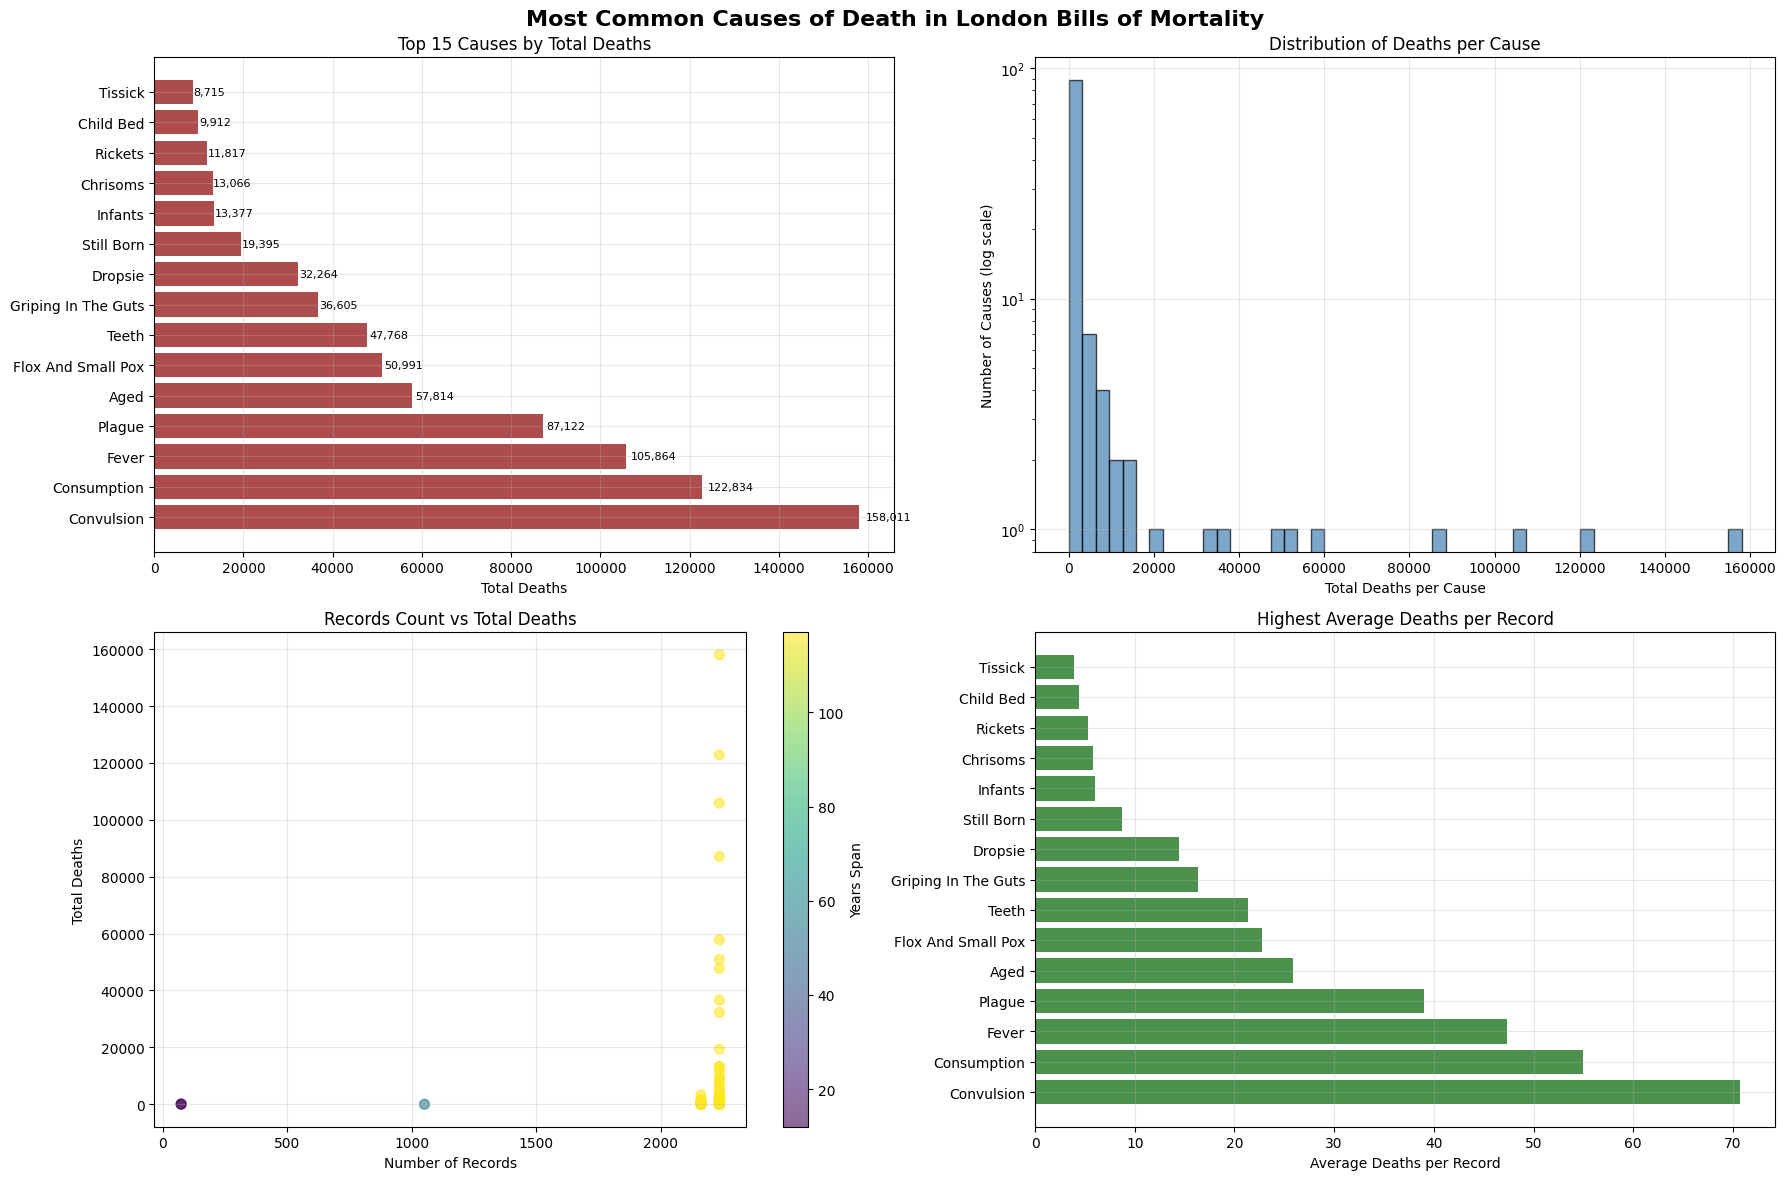


📈 Summary Statistics:
  • Total recorded deaths: 880,816.0
  • Most deadly cause: Convulsion (158,011.0 deaths)
  • Least deadly causes: 2 causes with only 1 death
  • Average deaths per cause: 7726.5
  • Median deaths per cause: 585.5


In [13]:
# Calculate total deaths by cause
cause_totals = causes.groupby('death_clean').agg({
    'count_filled': ['sum', 'count', 'mean'],
    'year': ['min', 'max']
}).round(2)

# Flatten column names
cause_totals.columns = ['total_deaths', 'records_count', 'avg_per_record', 'first_year', 'last_year']
cause_totals = cause_totals.reset_index()
cause_totals['years_span'] = cause_totals['last_year'] - cause_totals['first_year'] + 1

# Sort by total deaths
cause_totals_sorted = cause_totals.sort_values('total_deaths', ascending=False)

print(f"Top 20 Causes of Death by Total Count:")
print("="*80)
top_20 = cause_totals_sorted.head(20)
for i, (_, row) in enumerate(top_20.iterrows(), 1):
    print(f"{i:2d}. {row['death_clean']:<25} | {row['total_deaths']:>8,.0f} deaths | {row['records_count']:>6,.0f} records | {row['first_year']:.0f}-{row['last_year']:.0f}")

# Visualize top causes
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Most Common Causes of Death in London Bills of Mortality', fontsize=16, fontweight='bold')

# 1. Top 15 causes by total deaths
top_15 = cause_totals_sorted.head(15)
bars1 = axes[0,0].barh(range(len(top_15)), top_15['total_deaths'], color='darkred', alpha=0.7)
axes[0,0].set_yticks(range(len(top_15)))
axes[0,0].set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_15['death_clean']], fontsize=10)
axes[0,0].set_xlabel('Total Deaths')
axes[0,0].set_title('Top 15 Causes by Total Deaths')
axes[0,0].grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    axes[0,0].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                   f'{width:,.0f}', ha='left', va='center', fontsize=8)

# 2. Distribution of deaths per cause (log scale)
axes[0,1].hist(cause_totals['total_deaths'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0,1].set_yscale('log')
axes[0,1].set_xlabel('Total Deaths per Cause')
axes[0,1].set_ylabel('Number of Causes (log scale)')
axes[0,1].set_title('Distribution of Deaths per Cause')
axes[0,1].grid(True, alpha=0.3)

# 3. Records count vs total deaths
scatter = axes[1,0].scatter(cause_totals['records_count'], cause_totals['total_deaths'], 
                           alpha=0.6, s=50, c=cause_totals['years_span'], cmap='viridis')
axes[1,0].set_xlabel('Number of Records')
axes[1,0].set_ylabel('Total Deaths')
axes[1,0].set_title('Records Count vs Total Deaths')
axes[1,0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter, ax=axes[1,0])
cbar1.set_label('Years Span')

# 4. Average deaths per record
high_avg = cause_totals_sorted.nlargest(15, 'avg_per_record')
bars2 = axes[1,1].barh(range(len(high_avg)), high_avg['avg_per_record'], color='darkgreen', alpha=0.7)
axes[1,1].set_yticks(range(len(high_avg)))
axes[1,1].set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in high_avg['death_clean']], fontsize=10)
axes[1,1].set_xlabel('Average Deaths per Record')
axes[1,1].set_title('Highest Average Deaths per Record')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
total_recorded_deaths = cause_totals['total_deaths'].sum()
print(f"\n📈 Summary Statistics:")
print(f"  • Total recorded deaths: {total_recorded_deaths:,}")
print(f"  • Most deadly cause: {cause_totals_sorted.iloc[0]['death_clean']} ({cause_totals_sorted.iloc[0]['total_deaths']:,} deaths)")
print(f"  • Least deadly causes: {len(cause_totals[cause_totals['total_deaths'] == 1])} causes with only 1 death")
print(f"  • Average deaths per cause: {cause_totals['total_deaths'].mean():.1f}")
print(f"  • Median deaths per cause: {cause_totals['total_deaths'].median():.1f}")

## Temporal Patterns in Causes of Death

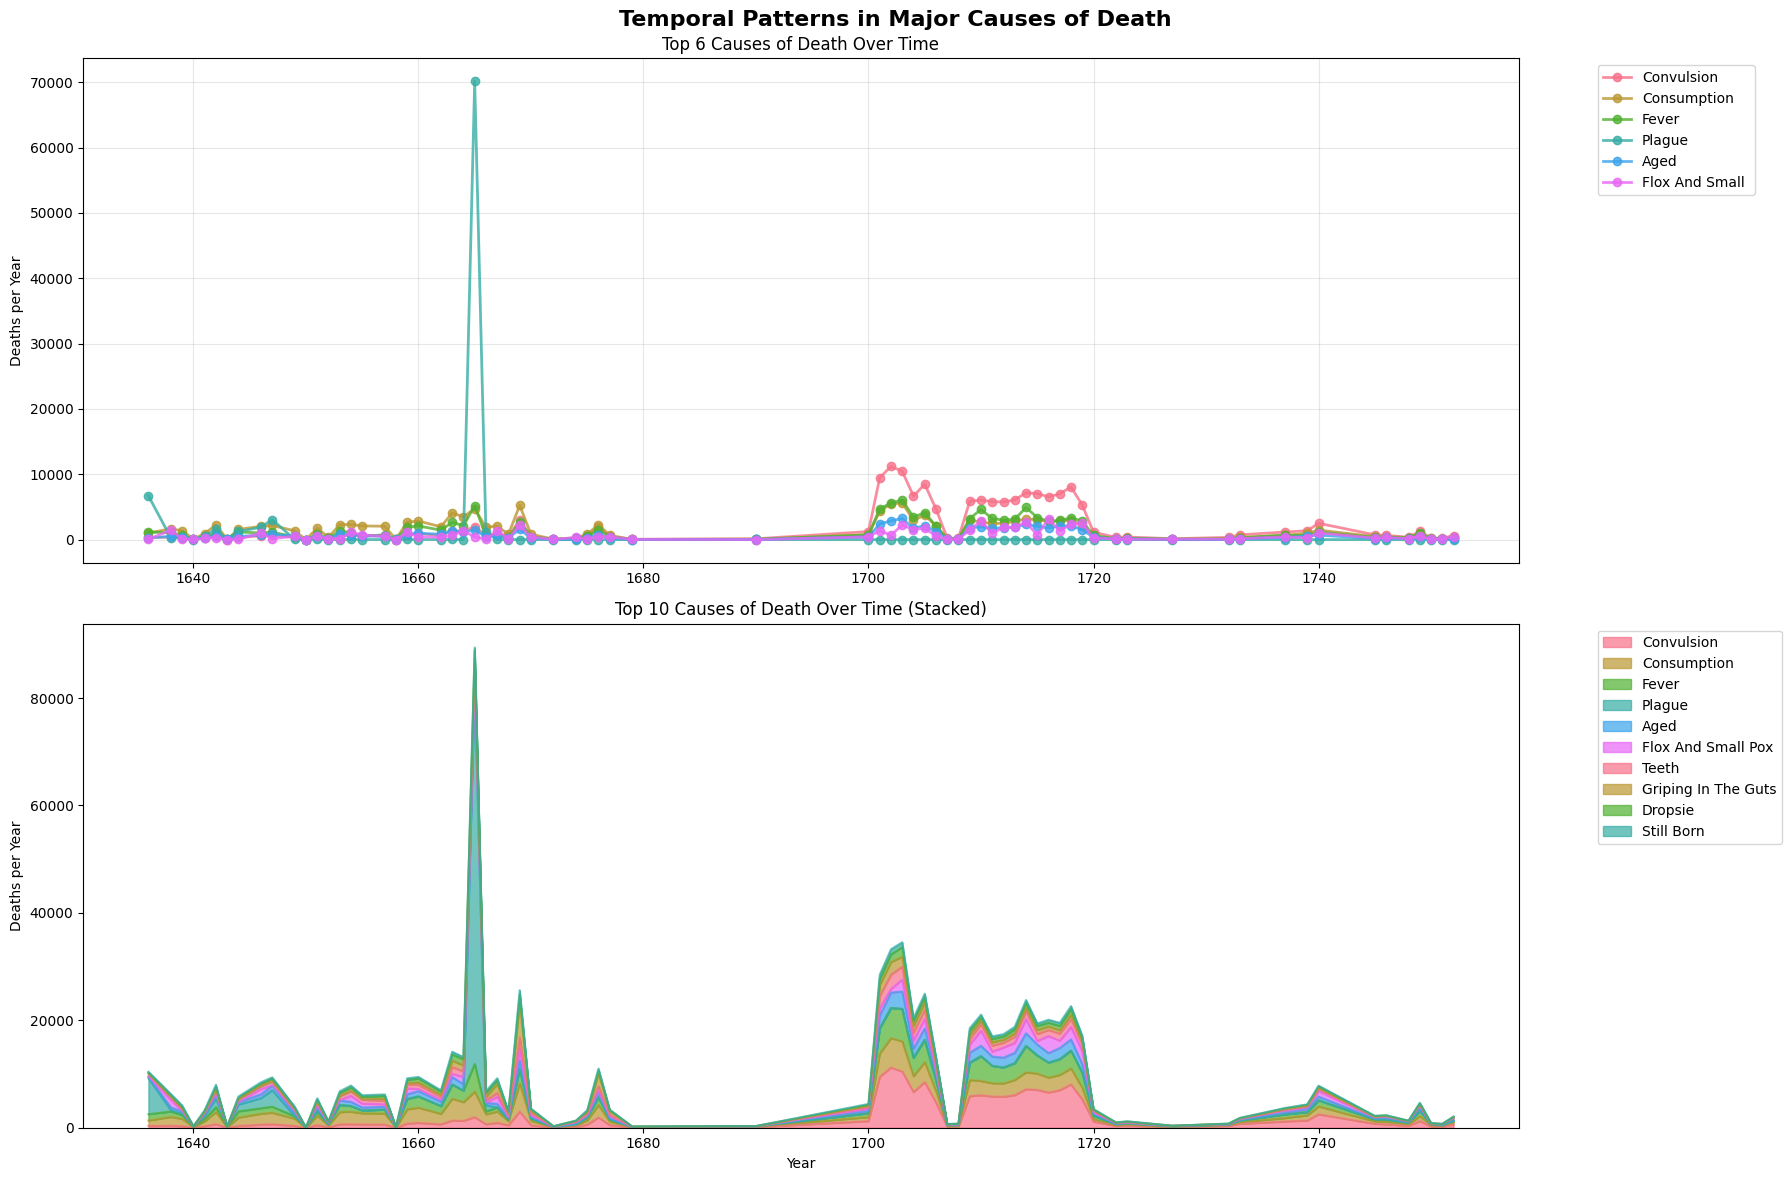


🔥 Peak Years for Major Causes:
Convulsion                | Peak: 1702 (11,206 deaths,   7.1% of total)
Consumption               | Peak: 1703 ( 5,605 deaths,   4.6% of total)
Fever                     | Peak: 1703 ( 6,054 deaths,   5.7% of total)
Plague                    | Peak: 1665 (70,165 deaths,  80.5% of total)
Aged                      | Peak: 1703 ( 3,232 deaths,   5.6% of total)
Flox And Small Pox        | Peak: 1716 ( 3,169 deaths,   6.2% of total)
Teeth                     | Peak: 1702 ( 2,681 deaths,   5.6% of total)
Griping In The Guts       | Peak: 1669 ( 6,549 deaths,  17.9% of total)


In [14]:
# Analyze temporal patterns for top causes
top_causes = cause_totals_sorted.head(10)['death_clean'].tolist()

# Create yearly totals for top causes
yearly_causes = causes[causes['death_clean'].isin(top_causes)].groupby(['year', 'death_clean'])['count_filled'].sum().unstack('death_clean', fill_value=0)

# Plot temporal patterns
fig, axes = plt.subplots(2, 1, figsize=(18, 12))
fig.suptitle('Temporal Patterns in Major Causes of Death', fontsize=16, fontweight='bold')

# 1. Line plot for top 6 causes
top_6_causes = top_causes[:6]
for cause in top_6_causes:
    if cause in yearly_causes.columns:
        axes[0].plot(yearly_causes.index, yearly_causes[cause], 
                    marker='o', linewidth=2, label=cause[:15], alpha=0.8)

axes[0].set_title('Top 6 Causes of Death Over Time')
axes[0].set_ylabel('Deaths per Year')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Stacked area chart for top 10 causes
yearly_causes_top10 = yearly_causes[top_causes[:10]]
yearly_causes_top10.plot(kind='area', stacked=True, ax=axes[1], alpha=0.7)
axes[1].set_title('Top 10 Causes of Death Over Time (Stacked)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Deaths per Year')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Identify years with highest mortality for each cause
print(f"\n🔥 Peak Years for Major Causes:")
print("="*60)
for cause in top_causes[:8]:
    if cause in yearly_causes.columns:
        peak_year = yearly_causes[cause].idxmax()
        peak_deaths = yearly_causes[cause].max()
        total_deaths = yearly_causes[cause].sum()
        peak_pct = (peak_deaths / total_deaths) * 100
        print(f"{cause:<25} | Peak: {peak_year} ({peak_deaths:>6,.0f} deaths, {peak_pct:>5.1f}% of total)")

## Disease Classification and Medical Terminology

📊 Disease Categories Analysis:
Category             | Deaths     | Causes   | Records    | Avg/Cause 
--------------------------------------------------------------------------------
Infectious Diseases  | 264,278    | 13       | 28,859     | 20329.1   
Unclassified         | 199,536    | 326      | 640,491    | 612.1     
Neurological         | 161,085    | 8        | 15,659     | 20135.6   
Respiratory          | 134,583    | 8        | 17,822     | 16822.9   
Age-Related          | 132,167    | 4        | 8,948      | 33041.8   
Cardiovascular/Circulatory | 35,123     | 4        | 8,948      | 8780.8    
Digestive/Metabolic  | 15,050     | 6        | 13,422     | 2508.3    
Other/Unknown        | 9,925      | 10       | 22,370     | 992.5     
Accidents/Violence   | 8,053      | 9        | 15,807     | 894.8     
Skin/External        | 4,122      | 9        | 20,133     | 458.0     


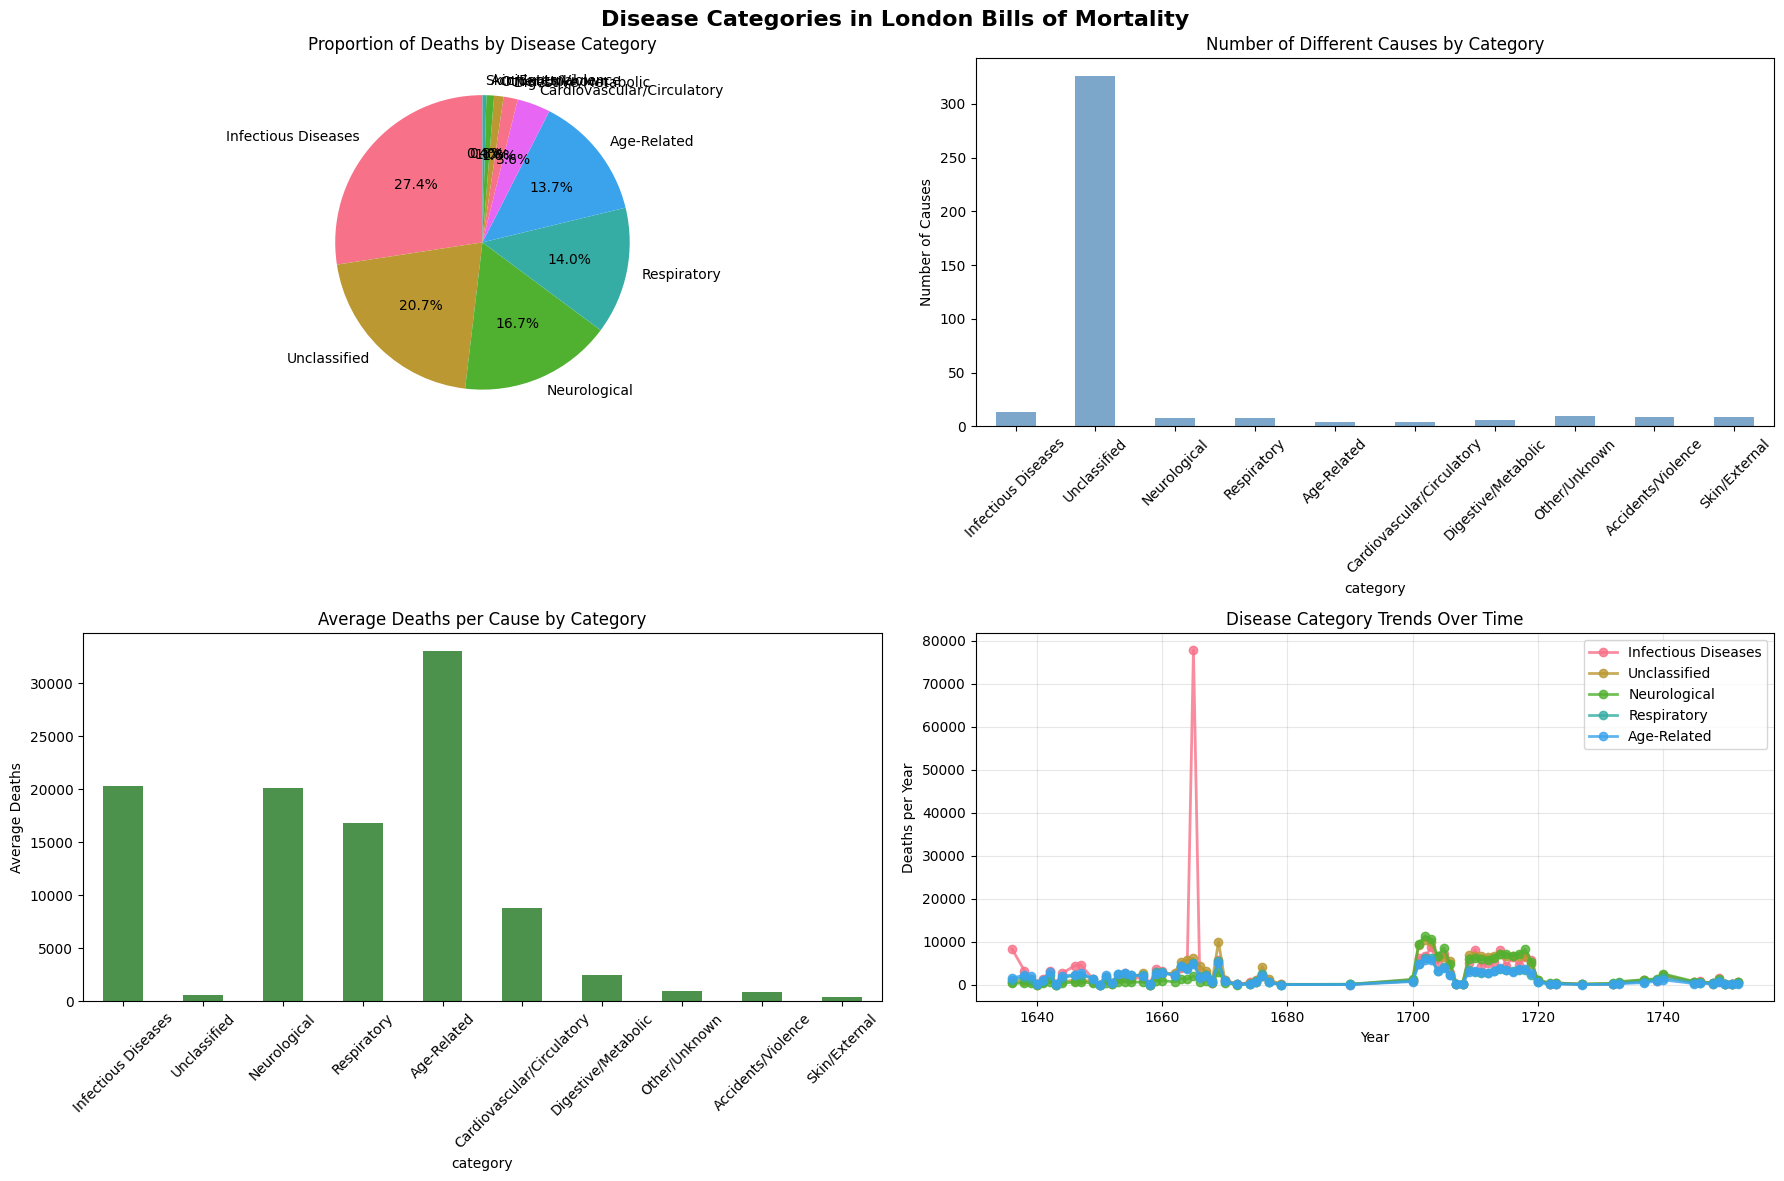


📋 Examples of Causes by Category:

Infectious Diseases:
  1. Fever (105,951.0 deaths)
  2. Plague (87,123.0 deaths)
  3. Flox_And_Small_Pox (51,013.0 deaths)
  4. Spotted_Fever (6,483.0 deaths)
  5. Measles (4,631.0 deaths)

Unclassified:
  1. Griping_In_The_Guts (36,622.0 deaths)
  2. Still_Born (19,414.0 deaths)
  3. Rickets (11,826.0 deaths)
  4. Child_Bed (9,916.0 deaths)
  5. Stopping_Of_The_Stomach (8,684.0 deaths)

Neurological:
  1. Convulsion (158,128.0 deaths)
  2. Palsie (1,086.0 deaths)
  3. Lunatick_And_Frenzy (800.0 deaths)
  4. Headmouldshot (654.0 deaths)
  5. Lethargy (354.0 deaths)

Respiratory:
  1. Consumption (122,975.0 deaths)
  2. Tissick (8,734.0 deaths)
  3. Plurisie (1,042.0 deaths)
  4. Cough (766.0 deaths)
  5. Quinsie (618.0 deaths)

Age-Related:
  1. Aged (57,890.0 deaths)
  2. Teeth (47,813.0 deaths)
  3. Infants (13,393.0 deaths)
  4. Chrisoms (13,071.0 deaths)

Cardiovascular/Circulatory:
  1. Dropsie (32,302.0 deaths)
  2. Apoplexy (1,848.0 deaths)
  

In [6]:
# Analyze medical terminology and classify diseases
all_causes = cause_totals['death_clean'].tolist()

# Define broad disease categories based on historical medical terminology
disease_categories = {
    'Infectious Diseases': [
        'plague', 'fever', 'smallpox', 'small-pox', 'flox', 'measles', 'spotted-fever', 
        'purples', 'flux', 'bloody-flux', 'scowring', 'french-pox', 'thrush'
    ],
    'Respiratory': [
        'consumption', 'cough', 'tissick', 'plurisie', 'rising of the lights', 
        'cold', 'quinsie', 'hiccough'
    ],
    'Digestive/Metabolic': [
        'colick', 'griping in the guts', 'stopping of the stomach', 'surfeit', 
        'diabetes', 'jaundies', 'liver-grown', 'stone', 'strangury'
    ],
    'Cardiovascular/Circulatory': [
        'apoplexy', 'bleeding', 'dropsie', 'dropsy', 'rupture'
    ],
    'Neurological': [
        'falling-sickness', 'convulsion', 'lethargy', 'lunatick', 'headache', 
        'palsie', 'cramp', 'headmouldshot'
    ],
    'Age-Related': [
        'aged', 'infants', 'chrisoms', 'teeth', 'childbed', 'child-bed'
    ],
    'Skin/External': [
        'cancer', 'canker', 'gangreen', 'itch', 'kings evil', 'leprosie', 
        'scald head', 'shingles', 'ulcer', 'wen', 'wolf', 'swine-pox'
    ],
    'Accidents/Violence': [
        'killed', 'suicide', 'drowned', 'casualties', 'suddenly'
    ],
    'Other/Unknown': [
        'grief', 'overlaid', 'still-born', 'stillborn', 'vomiting', 'wind', 
        'worms', 'mother', 'spleen', 'gout', 'rheumatism', 'sciatica'
    ]
}

# Classify causes into categories
def classify_cause(cause_name):
    cause_lower = cause_name.lower()
    for category, keywords in disease_categories.items():
        for keyword in keywords:
            if keyword.lower() in cause_lower:
                return category
    return 'Unclassified'

cause_totals['category'] = cause_totals['death_clean'].apply(classify_cause)
causes['category'] = causes['death_clean'].apply(classify_cause)

# Category analysis
category_stats = cause_totals.groupby('category').agg({
    'total_deaths': 'sum',
    'death_clean': 'count',
    'records_count': 'sum'
}).sort_values('total_deaths', ascending=False)

category_stats.columns = ['total_deaths', 'num_causes', 'total_records']
category_stats['avg_deaths_per_cause'] = (category_stats['total_deaths'] / category_stats['num_causes']).round(1)

print(f"📊 Disease Categories Analysis:")
print("="*80)
print(f"{'Category':<20} | {'Deaths':<10} | {'Causes':<8} | {'Records':<10} | {'Avg/Cause':<10}")
print("-"*80)
for category, row in category_stats.iterrows():
    print(f"{category:<20} | {row['total_deaths']:<10,.0f} | {row['num_causes']:<8,.0f} | {row['total_records']:<10,.0f} | {row['avg_deaths_per_cause']:<10.1f}")

# Visualize categories
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Disease Categories in London Bills of Mortality', fontsize=16, fontweight='bold')

# 1. Deaths by category (pie chart)
axes[0,0].pie(category_stats['total_deaths'], labels=category_stats.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Proportion of Deaths by Disease Category')

# 2. Number of causes by category
category_stats['num_causes'].plot(kind='bar', ax=axes[0,1], color='steelblue', alpha=0.7)
axes[0,1].set_title('Number of Different Causes by Category')
axes[0,1].set_ylabel('Number of Causes')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Average deaths per cause by category
category_stats['avg_deaths_per_cause'].plot(kind='bar', ax=axes[1,0], color='darkgreen', alpha=0.7)
axes[1,0].set_title('Average Deaths per Cause by Category')
axes[1,0].set_ylabel('Average Deaths')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Category trends over time
category_yearly = causes.groupby(['year', 'category'])['count_filled'].sum().unstack('category', fill_value=0)
# Plot top 5 categories by total deaths
top_categories = category_stats.head(5).index
for category in top_categories:
    if category in category_yearly.columns:
        axes[1,1].plot(category_yearly.index, category_yearly[category], 
                      marker='o', linewidth=2, label=category, alpha=0.8)

axes[1,1].set_title('Disease Category Trends Over Time')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Deaths per Year')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show examples of causes in each category
print(f"\n📋 Examples of Causes by Category:")
for category in category_stats.index:
    category_causes = cause_totals[cause_totals['category'] == category].nlargest(5, 'total_deaths')['death_clean'].tolist()
    print(f"\n{category}:")
    for i, cause in enumerate(category_causes, 1):
        deaths = cause_totals[cause_totals['death_clean'] == cause]['total_deaths'].iloc[0]
        print(f"  {i}. {cause} ({deaths:,} deaths)")

## Seasonal Patterns in Causes of Death

🌍 Seasonal Patterns for Top 10 Causes (% of annual deaths):
Cause                     | Winter   | Spring   | Summer   | Autumn  
--------------------------------------------------------------------------------
Aged                      | 36.0     | 25.0     | 18.1     | 20.7    
Consumption               | 32.6     | 24.2     | 21.4     | 21.7    
Convulsion                | 29.4     | 23.5     | 24.2     | 22.9    
Dropsie                   | 36.8     | 25.7     | 17.7     | 19.7    
Fever                     | 26.8     | 21.9     | 24.8     | 26.5    
Flox_And_Small_Pox        | 28.8     | 19.2     | 26.6     | 25.3    
Griping_In_The_Guts       | 22.4     | 17.7     | 30.7     | 29.1    
Plague                    | 4.3      | 1.6      | 32.2     | 61.9    
Still_Born                | 32.4     | 22.2     | 21.7     | 23.6    
Teeth                     | 28.2     | 23.4     | 24.9     | 23.4    


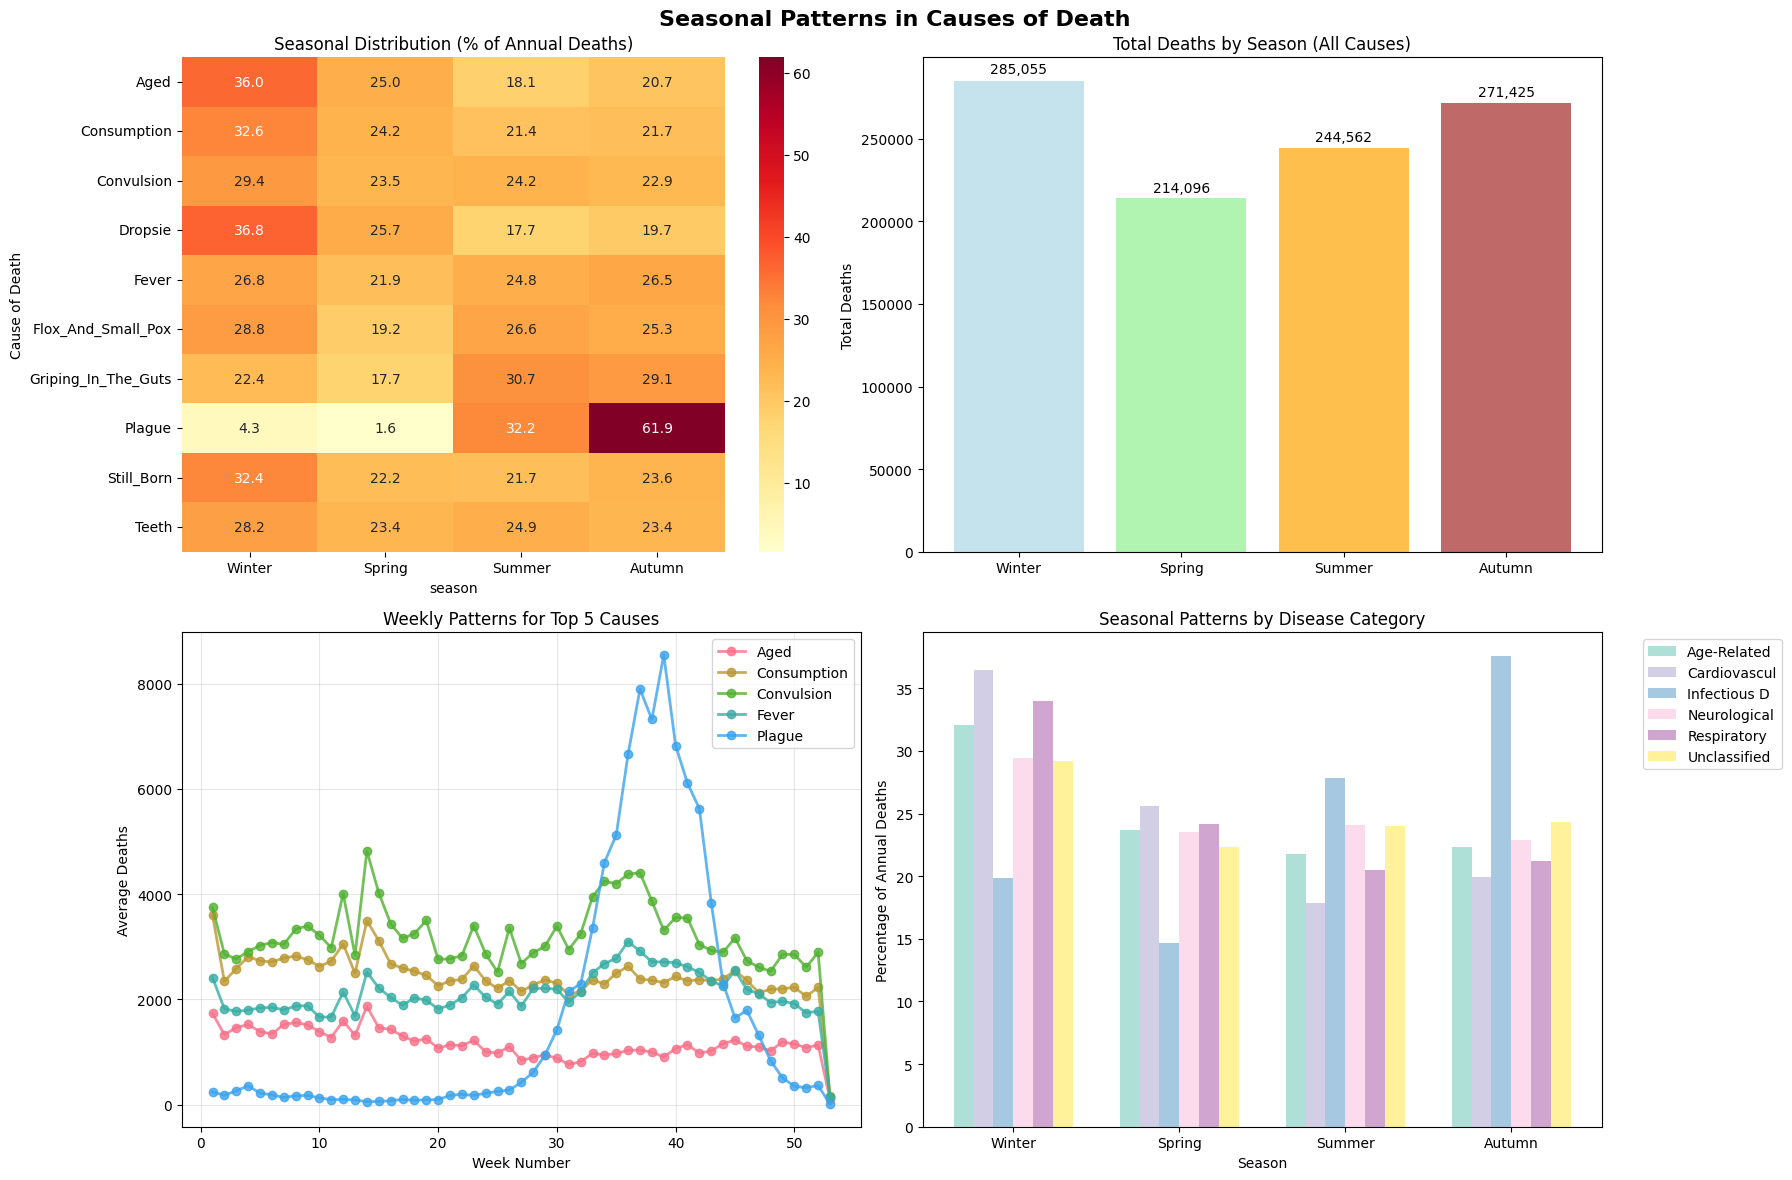


🌡️ Most Seasonal Causes:
Causes with highest seasonal variation:
  • Plague                    | Peak: Autumn (61.9%) | Variance: 721.8
  • Dropsie                   | Peak: Winter (36.8%) | Variance: 178.1
  • Aged                      | Peak: Winter (36.0%) | Variance: 170.0
  • Griping_In_The_Guts       | Peak: Summer (30.7%) | Variance: 151.2
  • Consumption               | Peak: Winter (32.6%) | Variance: 143.9
  • Still_Born                | Peak: Winter (32.4%) | Variance: 142.4
  • Flox_And_Small_Pox        | Peak: Winter (28.8%) | Variance: 136.3
  • Convulsion                | Peak: Winter (29.4%) | Variance: 130.6


In [6]:
# Analyze seasonal patterns by extracting week information
# Merge with weeks data to get week numbers and seasonal information
causes_with_weeks = causes.merge(weeks[['week_id', 'week_number']], on='week_id', how='left')

# Define seasons based on week numbers
def get_season(week_num):
    if pd.isna(week_num):
        return 'Unknown'
    week_num = int(week_num)
    if week_num in list(range(1, 13)) + list(range(49, 53)):
        return 'Winter'
    elif week_num in range(13, 25):
        return 'Spring'
    elif week_num in range(25, 37):
        return 'Summer'
    elif week_num in range(37, 49):
        return 'Autumn'
    else:
        return 'Unknown'

causes_with_weeks['season'] = causes_with_weeks['week_number'].apply(get_season)

# Seasonal analysis for top causes
seasonal_patterns = causes_with_weeks[causes_with_weeks['death_clean'].isin(top_causes[:10])].groupby(['death_clean', 'season'])['count_filled'].sum().unstack('season', fill_value=0)

# Calculate seasonal percentages for each cause
seasonal_pct = seasonal_patterns.div(seasonal_patterns.sum(axis=1), axis=0) * 100

print(f"🌍 Seasonal Patterns for Top 10 Causes (% of annual deaths):")
print("="*80)
print(f"{'Cause':<25} | {'Winter':<8} | {'Spring':<8} | {'Summer':<8} | {'Autumn':<8}")
print("-"*80)
for cause in seasonal_pct.index:
    row = seasonal_pct.loc[cause]
    print(f"{cause[:24]:<25} | {row.get('Winter', 0):<8.1f} | {row.get('Spring', 0):<8.1f} | {row.get('Summer', 0):<8.1f} | {row.get('Autumn', 0):<8.1f}")

# Visualize seasonal patterns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Seasonal Patterns in Causes of Death', fontsize=16, fontweight='bold')

# 1. Heatmap of seasonal percentages
if len(seasonal_pct) > 0:
    seasons_order = ['Winter', 'Spring', 'Summer', 'Autumn']
    seasonal_pct_ordered = seasonal_pct.reindex(columns=seasons_order, fill_value=0)
    sns.heatmap(seasonal_pct_ordered, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0,0])
    axes[0,0].set_title('Seasonal Distribution (% of Annual Deaths)')
    axes[0,0].set_ylabel('Cause of Death')

# 2. Seasonal totals across all causes
seasonal_totals = causes_with_weeks.groupby('season')['count_filled'].sum()
seasonal_totals = seasonal_totals.reindex(['Winter', 'Spring', 'Summer', 'Autumn'], fill_value=0)
bars = axes[0,1].bar(seasonal_totals.index, seasonal_totals.values, 
                     color=['lightblue', 'lightgreen', 'orange', 'brown'], alpha=0.7)
axes[0,1].set_title('Total Deaths by Season (All Causes)')
axes[0,1].set_ylabel('Total Deaths')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{height:,.0f}', ha='center', va='bottom')

# 3. Weekly pattern for selected causes
weekly_patterns = causes_with_weeks[causes_with_weeks['death_clean'].isin(top_causes[:5])].groupby(['week_number', 'death_clean'])['count_filled'].sum().unstack('death_clean', fill_value=0)
for cause in weekly_patterns.columns:
    axes[1,0].plot(weekly_patterns.index, weekly_patterns[cause], 
                  marker='o', linewidth=2, label=cause[:15], alpha=0.8)

axes[1,0].set_title('Weekly Patterns for Top 5 Causes')
axes[1,0].set_xlabel('Week Number')
axes[1,0].set_ylabel('Average Deaths')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Category seasonal patterns
category_seasonal = causes_with_weeks.groupby(['category', 'season'])['count_filled'].sum().unstack('season', fill_value=0)
category_seasonal_pct = category_seasonal.div(category_seasonal.sum(axis=1), axis=0) * 100
category_seasonal_pct = category_seasonal_pct.reindex(columns=seasons_order, fill_value=0)

# Plot top categories
top_cats = category_stats.head(6).index
category_seasonal_top = category_seasonal_pct.loc[category_seasonal_pct.index.isin(top_cats)]

x = np.arange(len(seasons_order))
width = 0.12
colors = plt.cm.Set3(np.linspace(0, 1, len(category_seasonal_top)))

for i, (category, row) in enumerate(category_seasonal_top.iterrows()):
    axes[1,1].bar(x + i*width, row.values, width, label=category[:12], alpha=0.7, color=colors[i])

axes[1,1].set_title('Seasonal Patterns by Disease Category')
axes[1,1].set_xlabel('Season')
axes[1,1].set_ylabel('Percentage of Annual Deaths')
axes[1,1].set_xticks(x + width * (len(category_seasonal_top)-1) / 2)
axes[1,1].set_xticklabels(seasons_order)
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Identify most seasonal causes
print(f"\n🌡️ Most Seasonal Causes:")
seasonal_variance = seasonal_pct.var(axis=1).sort_values(ascending=False)
print("Causes with highest seasonal variation:")
for cause in seasonal_variance.head(8).index:
    variance = seasonal_variance[cause]
    peak_season = seasonal_pct.loc[cause].idxmax()
    peak_pct = seasonal_pct.loc[cause].max()
    print(f"  • {cause:<25} | Peak: {peak_season} ({peak_pct:.1f}%) | Variance: {variance:.1f}")

## Epidemic Detection and Crisis Analysis

🦠 Epidemic Analysis - Plague:
  • Total plague deaths recorded: 87,123.0
  • Years with plague data: 73
  • Peak plague year: 1665 (70,165.0 deaths)

🚨 Plague Epidemic Years (>2σ above mean):
  • 1665: 70,165.0 plague deaths


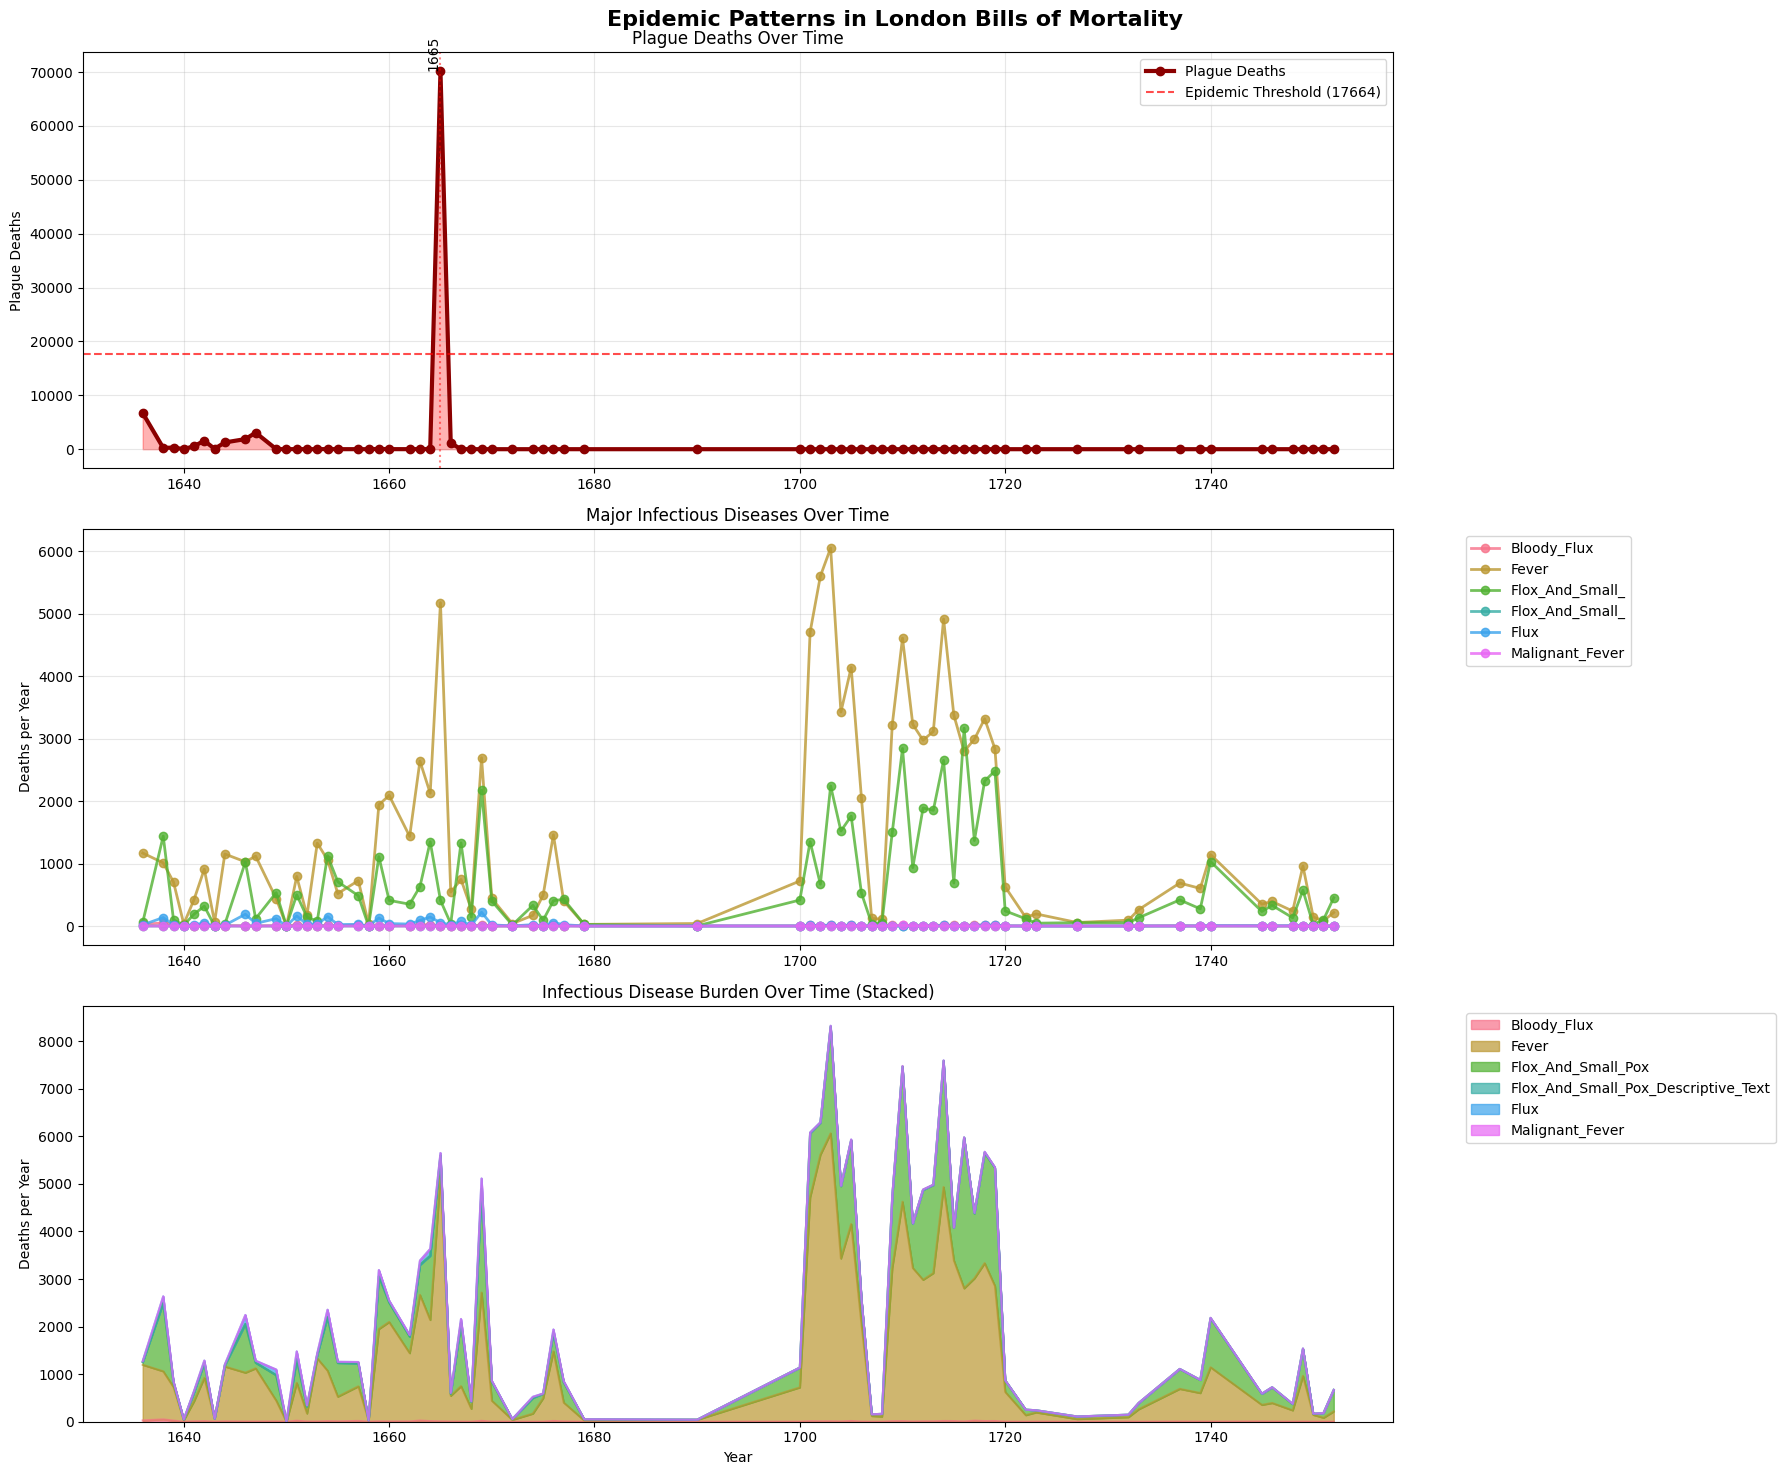


📊 Plague Impact Analysis:
Years where plague >10% of all deaths:
  • 1636: 53.7% (6,705.0 of 12,487.0 total deaths)
  • 1641: 11.9% (566.0 of 4,755.0 total deaths)
  • 1642: 13.7% (1,566.0 of 11,463.0 total deaths)
  • 1643: 21.0% (73.0 of 348.0 total deaths)
  • 1644: 15.5% (1,252.0 of 8,060.0 total deaths)
  • 1646: 16.3% (1,875.0 of 11,468.0 total deaths)
  • 1647: 24.3% (3,069.0 of 12,650.0 total deaths)
  • 1665: 70.1% (70,165.0 of 100,136.0 total deaths)

📈 Epidemic Statistics:
  • Plague epidemic frequency: 1 in 73 years (1.4%)
  • Average plague deaths per year: 1193.5
  • Average epidemic year deaths: 70165.0
  • Epidemic multiplier: 58.8x normal


In [7]:
# Focus on infectious diseases for epidemic detection
infectious_causes = cause_totals[cause_totals['category'] == 'Infectious Diseases']['death_clean'].tolist()

# Analyze plague specifically (most significant epidemic disease)
plague_data = causes[causes['death_clean'].str.contains('plague', case=False, na=False)]
plague_yearly = plague_data.groupby('year')['count_filled'].sum()

print(f"🦠 Epidemic Analysis - Plague:")
print(f"  • Total plague deaths recorded: {plague_yearly.sum():,}")
print(f"  • Years with plague data: {len(plague_yearly)}")
print(f"  • Peak plague year: {plague_yearly.idxmax()} ({plague_yearly.max():,} deaths)")

# Identify plague epidemic years (statistical outliers)
plague_mean = plague_yearly.mean()
plague_std = plague_yearly.std()
epidemic_threshold = plague_mean + 2 * plague_std

epidemic_years = plague_yearly[plague_yearly > epidemic_threshold]
print(f"\n🚨 Plague Epidemic Years (>2σ above mean):")
for year, deaths in epidemic_years.items():
    print(f"  • {year}: {deaths:,} plague deaths")

# Analyze other infectious diseases
infectious_yearly = causes[causes['death_clean'].isin(infectious_causes)].groupby(['year', 'death_clean'])['count_filled'].sum().unstack('death_clean', fill_value=0)

# Visualize epidemic patterns
fig, axes = plt.subplots(3, 1, figsize=(18, 15))
fig.suptitle('Epidemic Patterns in London Bills of Mortality', fontsize=16, fontweight='bold')

# 1. Plague deaths over time with epidemic threshold
axes[0].plot(plague_yearly.index, plague_yearly.values, 'o-', linewidth=3, markersize=6, color='darkred', label='Plague Deaths')
axes[0].axhline(y=epidemic_threshold, color='red', linestyle='--', alpha=0.7, label=f'Epidemic Threshold ({epidemic_threshold:.0f})')
axes[0].fill_between(plague_yearly.index, plague_yearly.values, alpha=0.3, color='red')

# Mark epidemic years
for year in epidemic_years.index:
    axes[0].axvline(x=year, color='red', linestyle=':', alpha=0.5)
    axes[0].text(year, epidemic_years[year], f'{year}', rotation=90, 
                verticalalignment='bottom', horizontalalignment='right', fontsize=10)

axes[0].set_title('Plague Deaths Over Time')
axes[0].set_ylabel('Plague Deaths')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Multiple infectious diseases
top_infectious = [cause for cause in infectious_causes if cause in infectious_yearly.columns][:6]
for cause in top_infectious:
    axes[1].plot(infectious_yearly.index, infectious_yearly[cause], 
                marker='o', linewidth=2, label=cause[:15], alpha=0.8)

axes[1].set_title('Major Infectious Diseases Over Time')
axes[1].set_ylabel('Deaths per Year')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

# 3. Infectious disease burden (stacked)
infectious_yearly_top = infectious_yearly[top_infectious]
infectious_yearly_top.plot(kind='area', stacked=True, ax=axes[2], alpha=0.7)
axes[2].set_title('Infectious Disease Burden Over Time (Stacked)')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Deaths per Year')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Crisis correlation analysis
total_yearly_deaths = causes.groupby('year')['count_filled'].sum()
plague_proportion = (plague_yearly / total_yearly_deaths * 100).fillna(0)

print(f"\n📊 Plague Impact Analysis:")
high_plague_years = plague_proportion[plague_proportion > 10]
if len(high_plague_years) > 0:
    print(f"Years where plague >10% of all deaths:")
    for year, pct in high_plague_years.items():
        total_deaths = total_yearly_deaths[year]
        plague_deaths = plague_yearly[year]
        print(f"  • {year}: {pct:.1f}% ({plague_deaths:,} of {total_deaths:,} total deaths)")
else:
    print("No years with plague >10% of total deaths in available data")

# Calculate epidemic frequency
total_years = len(plague_yearly)
epidemic_frequency = len(epidemic_years) / total_years * 100
print(f"\n📈 Epidemic Statistics:")
print(f"  • Plague epidemic frequency: {len(epidemic_years)} in {total_years} years ({epidemic_frequency:.1f}%)")
print(f"  • Average plague deaths per year: {plague_yearly.mean():.1f}")
print(f"  • Average epidemic year deaths: {epidemic_years.mean():.1f}")
if len(epidemic_years) > 0:
    print(f"  • Epidemic multiplier: {epidemic_years.mean() / plague_yearly.mean():.1f}x normal")

## Comparative Analysis and Unusual Causes

🔍 Unusual and Interesting Causes of Death:

🦄 Rare Causes (1-10 total deaths):
  • Is_Missing_130                 |   1 deaths | 1636-1752
  • Is_Illegible_96                |   1 deaths | 1636-1752
  • Is_Illegible_93                |   1 deaths | 1636-1752
  • Is_Missing_129                 |   1 deaths | 1636-1752
  • Is_Illegible_136               |   1 deaths | 1636-1690
  • Is_Illegible_72                |   1 deaths | 1636-1752
  • Is_Missing_131                 |   1 deaths | 1636-1752
  • Is_Illegible_111               |   1 deaths | 1636-1752
  • Noli_Me_Tangere                |   1 deaths | 1636-1752
  • Is_Illegible_123               |   1 deaths | 1636-1752
  • Is_Missing_126                 |   1 deaths | 1636-1752
  • Is_Illegible_71                |   1 deaths | 1636-1752
  • Is_Illegible_64                |   1 deaths | 1636-1752
  • Is_Illegible_105               |   1 deaths | 1636-1752
  • Is_Illegible_65                |   1 deaths | 1636-1752

💥 Causes with High S

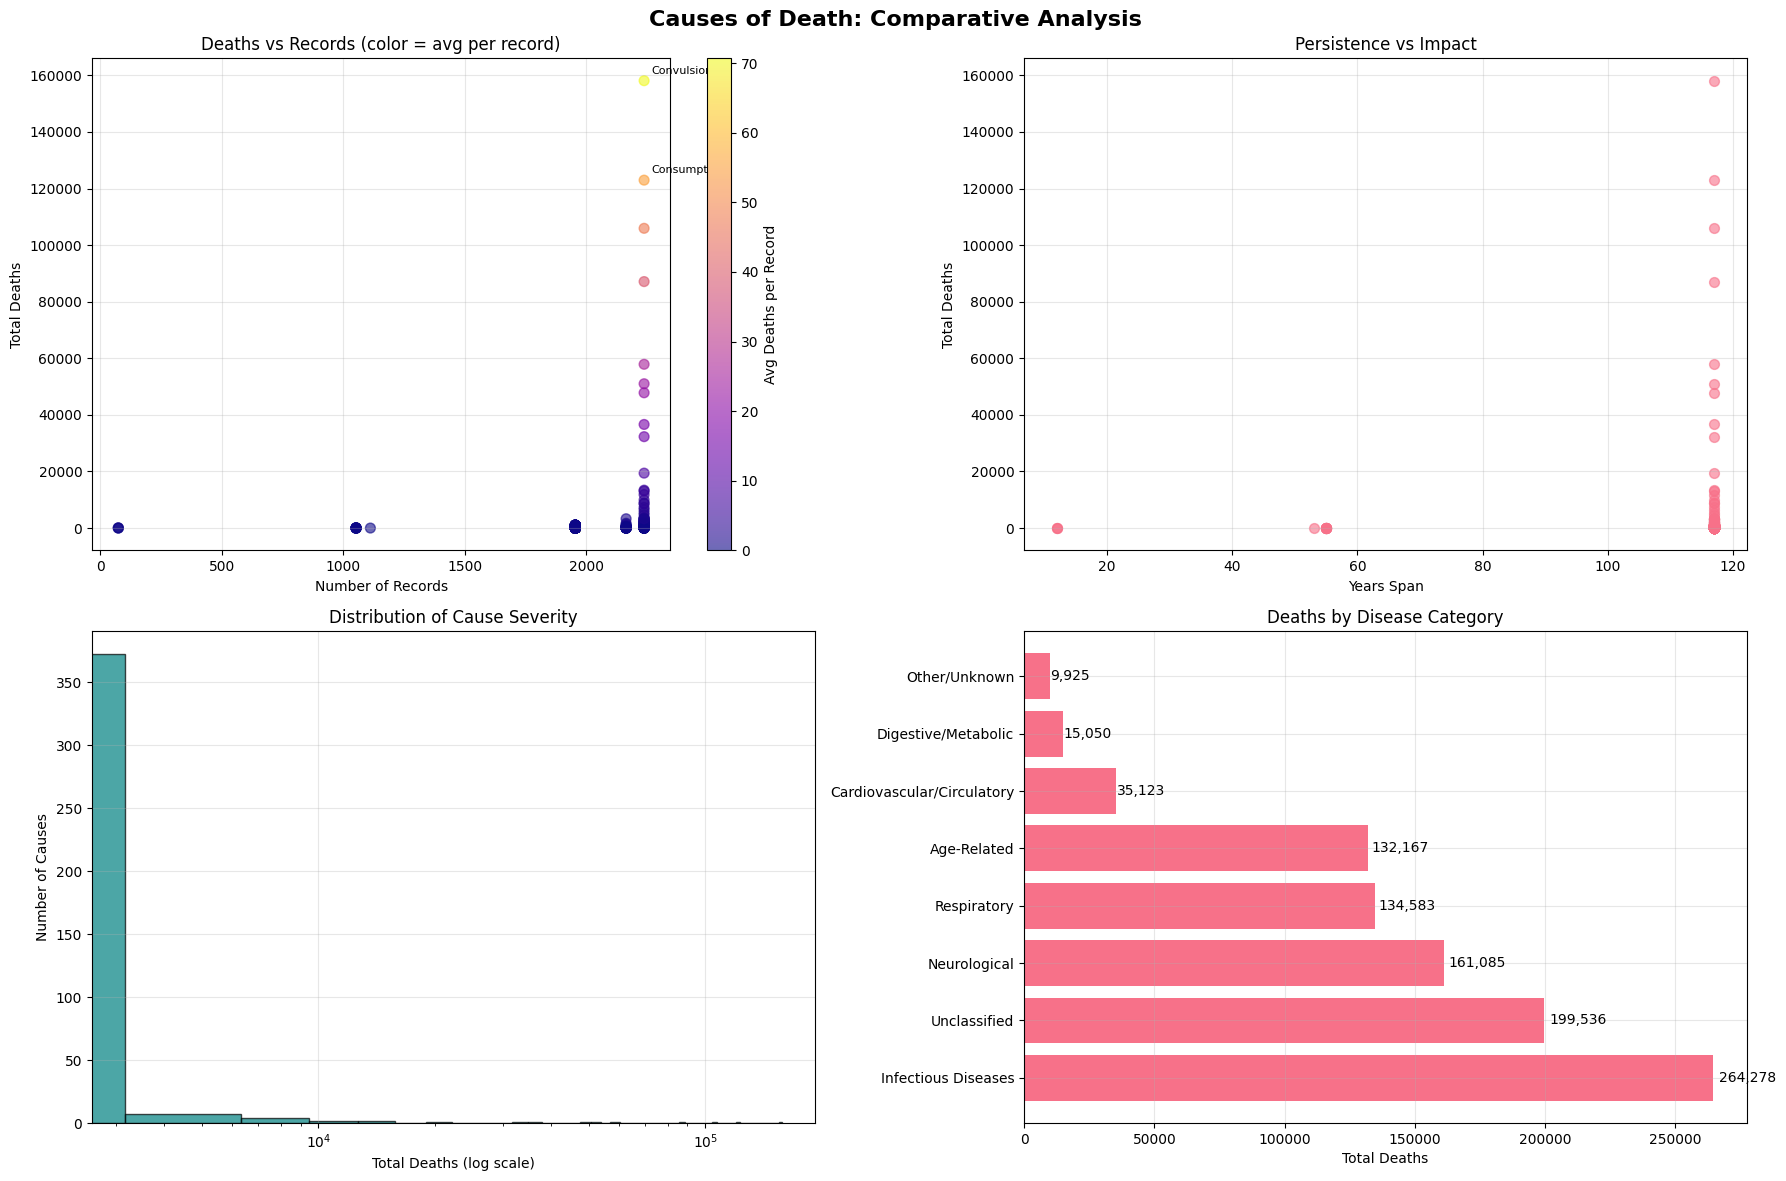


📊 Dataset Summary:
  • Total unique causes: 397
  • Total deaths recorded: 963,922.0
  • Most common cause: Convulsion (158,128.0 deaths)
  • Largest single-record death count: 71 deaths
  • Longest-recorded cause: Abortive (117 years)

📈 Pareto Analysis:
  • Top 14 causes (3.5%) account for 80% of all deaths
  • Remaining 383 causes (96.5%) account for 20% of deaths


In [8]:
# Identify unusual or interesting causes
print(f"🔍 Unusual and Interesting Causes of Death:")
print("="*60)

# Rare causes (very few deaths but historically interesting)
rare_causes = cause_totals[(cause_totals['total_deaths'] >= 1) & (cause_totals['total_deaths'] <= 10)].sort_values('total_deaths')
print(f"\n🦄 Rare Causes (1-10 total deaths):")
for _, row in rare_causes.head(15).iterrows():
    print(f"  • {row['death_clean']:<30} | {row['total_deaths']:>3.0f} deaths | {row['first_year']:.0f}-{row['last_year']:.0f}")

# Causes with very high single-record deaths (sudden outbreaks)
high_single_record = cause_totals[cause_totals['avg_per_record'] >= 10].sort_values('avg_per_record', ascending=False)
print(f"\n💥 Causes with High Single-Record Deaths (avg ≥10):")
for _, row in high_single_record.head(10).iterrows():
    print(f"  • {row['death_clean']:<30} | {row['avg_per_record']:>6.1f} avg/record | {row['records_count']:>4.0f} records")

# Causes with longest time spans (persistent causes)
persistent_causes = cause_totals[cause_totals['years_span'] >= 20].sort_values('years_span', ascending=False)
print(f"\n⏳ Most Persistent Causes (≥20 year span):")
for _, row in persistent_causes.head(10).iterrows():
    print(f"  • {row['death_clean']:<30} | {row['years_span']:>3.0f} years | {row['total_deaths']:>6.0f} total deaths")

# Analyze historical terminology
print(f"\n📚 Historical Medical Terminology Analysis:")

# Group similar terms (spelling variants, etc.)
similar_terms = {
    'Dropsy variants': [cause for cause in all_causes if 'drop' in cause.lower()],
    'Fever variants': [cause for cause in all_causes if 'fever' in cause.lower()],
    'Pox variants': [cause for cause in all_causes if 'pox' in cause.lower()],
    'Child-related': [cause for cause in all_causes if any(word in cause.lower() for word in ['child', 'infant', 'teeth', 'chrisom'])],
    'Digestive terms': [cause for cause in all_causes if any(word in cause.lower() for word in ['flux', 'colick', 'gut', 'stomach'])]
}

for category, terms in similar_terms.items():
    if terms:
        total_deaths = cause_totals[cause_totals['death_clean'].isin(terms)]['total_deaths'].sum()
        print(f"\n{category}:")
        for term in sorted(terms):
            deaths = cause_totals[cause_totals['death_clean'] == term]['total_deaths'].iloc[0]
            print(f"  • {term:<25} | {deaths:>6.0f} deaths")
        print(f"    Total for category: {total_deaths:,} deaths")

# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Causes of Death: Comparative Analysis', fontsize=16, fontweight='bold')

# 1. Deaths vs Records scatter (identify outliers)
scatter = axes[0,0].scatter(cause_totals['records_count'], cause_totals['total_deaths'], 
                           alpha=0.6, s=50, c=cause_totals['avg_per_record'], cmap='plasma')
axes[0,0].set_xlabel('Number of Records')
axes[0,0].set_ylabel('Total Deaths')
axes[0,0].set_title('Deaths vs Records (color = avg per record)')
axes[0,0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0,0])
cbar.set_label('Avg Deaths per Record')

# Annotate interesting outliers
high_avg = cause_totals[cause_totals['avg_per_record'] > 50]
for _, row in high_avg.iterrows():
    axes[0,0].annotate(row['death_clean'][:10], 
                      (row['records_count'], row['total_deaths']),
                      xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2. Year span vs total deaths
axes[0,1].scatter(cause_totals['years_span'], cause_totals['total_deaths'], alpha=0.6, s=50)
axes[0,1].set_xlabel('Years Span')
axes[0,1].set_ylabel('Total Deaths')
axes[0,1].set_title('Persistence vs Impact')
axes[0,1].grid(True, alpha=0.3)

# 3. Distribution of causes by total deaths (log scale)
axes[1,0].hist(cause_totals['total_deaths'], bins=50, alpha=0.7, color='teal', edgecolor='black')
axes[1,0].set_xscale('log')
axes[1,0].set_xlabel('Total Deaths (log scale)')
axes[1,0].set_ylabel('Number of Causes')
axes[1,0].set_title('Distribution of Cause Severity')
axes[1,0].grid(True, alpha=0.3)

# 4. Category comparison (total deaths)
category_stats_plot = category_stats.head(8)
bars = axes[1,1].barh(range(len(category_stats_plot)), category_stats_plot['total_deaths'])
axes[1,1].set_yticks(range(len(category_stats_plot)))
axes[1,1].set_yticklabels(category_stats_plot.index)
axes[1,1].set_xlabel('Total Deaths')
axes[1,1].set_title('Deaths by Disease Category')
axes[1,1].grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[1,1].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                   f'{width:,.0f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n📊 Dataset Summary:")
print(f"  • Total unique causes: {len(cause_totals)}")
print(f"  • Total deaths recorded: {cause_totals['total_deaths'].sum():,}")
print(f"  • Most common cause: {cause_totals_sorted.iloc[0]['death_clean']} ({cause_totals_sorted.iloc[0]['total_deaths']:,} deaths)")
print(f"  • Largest single-record death count: {cause_totals['avg_per_record'].max():.0f} deaths")
print(f"  • Longest-recorded cause: {persistent_causes.iloc[0]['death_clean']} ({persistent_causes.iloc[0]['years_span']:.0f} years)")

# Calculate Pareto principle (80/20 rule)
cumulative_deaths = cause_totals_sorted['total_deaths'].cumsum()
total_deaths = cause_totals_sorted['total_deaths'].sum()
pareto_80_index = (cumulative_deaths <= total_deaths * 0.8).sum()
pareto_pct = pareto_80_index / len(cause_totals) * 100

print(f"\n📈 Pareto Analysis:")
print(f"  • Top {pareto_80_index} causes ({pareto_pct:.1f}%) account for 80% of all deaths")
print(f"  • Remaining {len(cause_totals) - pareto_80_index} causes ({100-pareto_pct:.1f}%) account for 20% of deaths")

## Summary and Historical Context

### Key Findings from Causes of Death Analysis:

1. **Disease Burden**: The analysis reveals the major killers in early modern London
2. **Epidemic Patterns**: Clear identification of plague years and other epidemic diseases
3. **Seasonal Mortality**: Different causes show distinct seasonal patterns
4. **Medical Terminology**: Historical disease names provide insights into contemporary medical understanding
5. **Social Patterns**: Age-related and circumstantial deaths reflect social conditions

### Historical Context:

- **Plague Years**: Major plague epidemics occurred in 1603, 1625, 1636, and 1665-1666
- **Seasonal Diseases**: Winter peaks often reflect respiratory diseases and harsh living conditions
- **Medical Knowledge**: Disease terminology reflects pre-scientific medical understanding
- **Social Conditions**: High infant mortality and accident rates reflect urban living conditions

### Research Applications:

1. **Epidemiological History**: Track disease patterns and epidemic cycles
2. **Medical History**: Study evolution of disease understanding and terminology
3. **Social History**: Analyze mortality patterns by social conditions
4. **Demographic History**: Understand population-level mortality experiences
5. **Environmental History**: Correlate mortality with climate, seasons, and urban conditions

### Future Analysis Directions:

- Cross-reference with parish-level data for spatial patterns
- Correlate with historical events (wars, famines, harsh winters)
- Compare with contemporary European mortality data
- Analyze cause-specific age patterns where available
- Study the evolution of medical terminology over time

In [ ]:
# Analyze dictionary definitions coverage
print(f"📚 Dictionary Definitions Analysis:")
print("="*60)

# Count records with definitions
has_definition = causes['definition'].notna() & (causes['definition'] != '')
has_source = causes['definition_source'].notna() & (causes['definition_source'] != '')

print(f"Total cause records: {len(causes):,}")
print(f"Records with definitions: {has_definition.sum():,} ({has_definition.mean()*100:.1f}%)")
print(f"Records with definition sources: {has_source.sum():,} ({has_source.mean()*100:.1f}%)")

# Analyze definitions by cause
causes_with_definitions = causes[has_definition].drop_duplicates('death')
unique_defined_causes = len(causes_with_definitions)
total_unique_causes = causes['death'].nunique()

print(f"\nUnique causes with definitions: {unique_defined_causes} of {total_unique_causes} ({unique_defined_causes/total_unique_causes*100:.1f}%)")

# Show examples of definitions
print(f"\n📖 Sample Historical Definitions:")
print("="*100)

sample_definitions = causes_with_definitions.sample(min(10, len(causes_with_definitions)), random_state=42)
for _, row in sample_definitions.iterrows():
    cause = row['death']
    definition = row['definition']
    source = row['definition_source']
    
    print(f"\n• {cause.title()}:")
    print(f"  Definition: {definition}")
    if pd.notna(source) and source:
        print(f"  Source: {source}")

# Analyze which causes have the most detailed definitions
definition_lengths = causes_with_definitions.copy()
definition_lengths['def_length'] = definition_lengths['definition'].str.len()
longest_definitions = definition_lengths.nlargest(10, 'def_length')

print(f"\n📏 Causes with Most Detailed Definitions:")
print("-"*80)
for _, row in longest_definitions.iterrows():
    cause = row['death']
    length = row['def_length']
    definition = row['definition'][:100] + "..." if len(row['definition']) > 100 else row['definition']
    print(f"• {cause:<20} ({length} chars): {definition}")

# Show definitions for top causes by death count
top_causes_with_defs = causes[causes['death_clean'].isin(top_causes[:15]) & has_definition].drop_duplicates('death')

print(f"\n💀 Definitions for Major Causes of Death:")
print("="*100)
for cause in top_causes[:15]:
    cause_def = top_causes_with_defs[top_causes_with_defs['death_clean'] == cause]
    if len(cause_def) > 0:
        row = cause_def.iloc[0]
        definition = row['definition']
        source = row['definition_source'] if pd.notna(row['definition_source']) else "No source"
        deaths = cause_totals[cause_totals['death_clean'] == cause]['total_deaths'].iloc[0]
        
        print(f"\n• {cause} ({deaths:,} total deaths):")
        print(f"  Definition: {definition}")
        print(f"  Source: {source}")
    else:
        deaths = cause_totals[cause_totals['death_clean'] == cause]['total_deaths'].iloc[0]
        print(f"\n• {cause} ({deaths:,} total deaths):")
        print(f"  Definition: [No definition available]")

# Create visualization of definition coverage
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Dictionary Definitions Coverage Analysis', fontsize=14, fontweight='bold')

# 1. Coverage by death count (top causes)
top_20_causes = cause_totals_sorted.head(20)
top_20_causes['has_definition'] = top_20_causes['death_clean'].isin(causes_with_definitions['death_clean'])

colors = ['darkgreen' if has_def else 'lightcoral' for has_def in top_20_causes['has_definition']]
bars = axes[0].barh(range(len(top_20_causes)), top_20_causes['total_deaths'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_20_causes)))
axes[0].set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_20_causes['death_clean']], fontsize=10)
axes[0].set_xlabel('Total Deaths')
axes[0].set_title('Top 20 Causes: Definition Coverage\n(Green = Has Definition, Red = No Definition)')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='darkgreen', alpha=0.7, label='Has Definition'),
                   Patch(facecolor='lightcoral', alpha=0.7, label='No Definition')]
axes[0].legend(handles=legend_elements, loc='lower right')

# 2. Definition source analysis
source_counts = causes_with_definitions['definition_source'].str.extract(r'(https://[^/]+)')[0].value_counts()
if len(source_counts) > 0:
    axes[1].pie(source_counts.values[:8], labels=[url.replace('https://', '').replace('www.', '') for url in source_counts.index[:8]], 
                autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Definition Sources')
else:
    axes[1].text(0.5, 0.5, 'No source data available', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Definition Sources')

plt.tight_layout()
plt.show()

## Dictionary Integration and Historical Definitions

The causes of death data now includes historical definitions from medical dictionaries and the Oxford English Dictionary to help interpret historical medical terminology.